# Section 6

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 16,
    'text.latex.preamble': r"\usepackage{amsmath}"
})

In [2]:
import irbasis3

## Generate IR basis by singular value expansion

In [3]:
# Create kenerl for lambda_ = 100 and beta = 10
# The default value of eps ``cutoff for singular values" is
# set to 2.2e-16.
# In this sample, we compute fewer basis functions.
lambda_ = 100
beta = 10
wmax = lambda_/beta
K = irbasis3.KernelFFlat(lambda_=100)
basis = irbasis3.FiniteTempBasis(
    K, statistics='F', beta=beta, eps=1e-10)

## Singular values

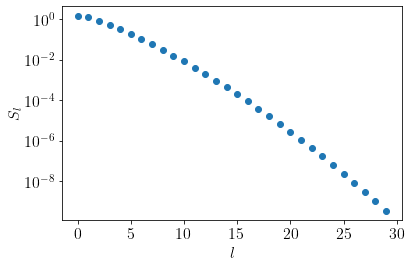

In [4]:
plt.semilogy(basis.s, marker='o', ls='')
plt.xlabel(r'$l$')
plt.ylabel(r'$S_l$')
plt.tight_layout()
plt.savefig('ir_basis_svals.pdf', transparent=True)

## $U_l(\tau)$ and $V_l(\omega)$

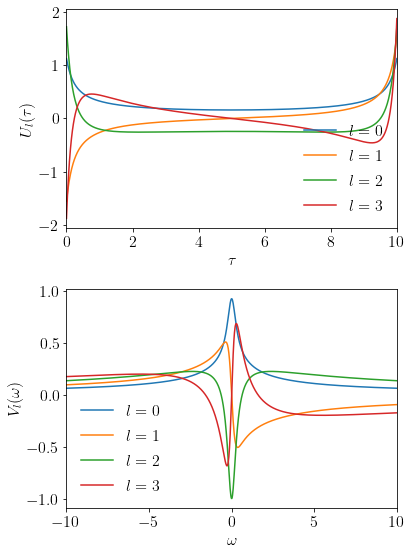

In [5]:
fig = plt.figure(figsize=(6,8))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
axes = [ax1, ax2]

taus = np.linspace(0, beta, 1000)
omegas = np.linspace(-wmax, wmax, 1000)

for l in range(4):
    ax1.plot(taus, basis.u[l](taus), label=f'$l={l}$')
    ax2.plot(omegas, basis.v[l](omegas), label=f'$l={l}$')

ax1.set_xlabel(r'$\tau$')
ax2.set_xlabel(r'$\omega$')
ax1.set_ylabel(r'$U_l(\tau)$')
ax2.set_ylabel(r'$V_l(\omega)$')
ax1.set_xlim([0,beta])
ax2.set_xlim([-wmax, wmax])

ax1.legend(loc='best', frameon=False)
ax2.legend(loc='best', frameon=False)
plt.tight_layout()
plt.savefig('ir_basis_functions.pdf', transparent=True)

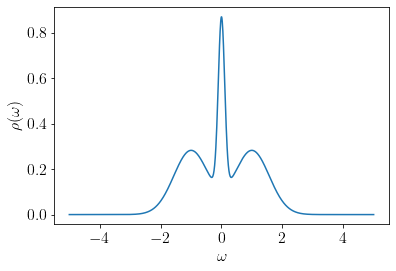

In [6]:
# Three Gaussian peaks (normalized to 1)
gaussian = lambda x, mu, sigma: np.exp(-((x-mu)/sigma)**2)/(np.sqrt(np.pi)*sigma)

rho = lambda omega: 0.2*gaussian(omega, 0.0, 0.15) + \
    0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)

omegas = np.linspace(-5, 5, 1000)
plt.xlabel(r'$\omega$')
plt.ylabel(r'$\rho(\omega)$')
plt.plot(omegas, rho(omegas))

In [7]:
# Set up Composite Gauss-Legendre quadrature
# Let -wmax = w_1 < w_2 < ... < w_{N-1} < w_N = wmax be a partition of [-wmax, wmax],
# where w_2, ..., w_{N-1} are the roots of the highest basis function in omega.
# We apply Gauss-Legendre quadrature to each integral. 
from numpy.polynomial.legendre import leggauss

def scale_quad(x, w, xmax, xmin):
    """ Scale weights and notes of quadrature to the interval [xmin, xmax] """
    assert xmin < xmax
    dx = xmax - xmin
    w_ = 0.5 * dx * w
    x_ = (0.5 * dx) * (x + 1) + xmin
    return x_, w_

# Roots of highest V_l
roots = basis.v[-1].roots()
bins = np.hstack((-wmax, roots, wmax))

x, w = leggauss(deg=20)
omegas_quad = []
weights_quad = []
for i in range(bins.size-1):
    x_, w_ = scale_quad(x, w, bins[i+1], bins[i])
    omegas_quad.append(x_)
    weights_quad.append(w_)
omegas_quad = np.hstack(omegas_quad)
weights_quad = np.hstack(weights_quad)

In [8]:
# Check orthogonality condition
for i in range(basis.size):
    for j in range(i, basis.size):
        print(i, j, weights_quad @ (basis.v[j](omegas_quad) * basis.v[i](omegas_quad)))

0 0 0.9999999999999999
0 1 1.9366561306022323e-17
0 2 3.411679304950871e-17
0 3 2.1736559492439855e-17
0 4 3.3274842299937935e-17
0 5 -1.8963373623129276e-17
0 6 -3.057788939588024e-17
0 7 1.0733601507606494e-17
0 8 3.914308655851573e-17
0 9 -3.223807397249867e-17
0 10 1.7774139365184238e-17
0 11 1.9264917352351807e-17
0 12 -3.773701186607359e-17
0 13 -2.1182599944935543e-17
0 14 -5.604647605392254e-17
0 15 -9.825582188149884e-19
0 16 6.0173220572945496e-18
0 17 8.673617379884035e-19
0 18 -8.907398473326222e-17
0 19 -1.0977546996415732e-18
0 20 -2.7647155398380363e-17
0 21 2.1412992906588713e-18
0 22 -1.2719046735970574e-16
0 23 2.392021043046144e-18
0 24 -9.359375253981117e-17
0 25 8.334804200982315e-18
0 26 -4.979198477139679e-17
0 27 -8.077306185017008e-18
0 28 -1.3992984288641042e-16
0 29 -6.451002926288751e-18
1 1 0.9999999999999997
1 2 2.3452648243577068e-17
1 3 -6.074920297707842e-18
1 4 6.945670167485263e-18
1 5 1.6191881819713205e-17
1 6 3.096752455161722e-18
1 7 2.38524477946